# Damped Harmonic Oscillator with forcing
We want to solve the damped harmonic oscillator equation with a forcing term:
$$
\frac{d^2x}{dt^2} + 2\gamma \frac{dx}{dt} + \omega_0^2 x = F(t)
$$
where $x$ is the displacement, $\gamma$ is the damping coefficient, $\omega_0$ is the natural frequency, and $F(t)$ is the forcing term.
We want to rewrite this equation in the form of a first-order system. We can do this by introducing a new variable $v = \frac{dx}{dt}$, which gives us the following system of equations:
$$
\frac{dx}{dt} = v
$$
$$
\frac{dv}{dt} = -2\gamma v - \omega_0^2 x + F(t)
$$
We can now write this system in matrix form:
$$
\frac{d}{dt} \begin{pmatrix} x \\ v \end{pmatrix} = \begin{pmatrix} 0 & 1 \\ -\omega_0^2 & -2\gamma \end{pmatrix} \begin{pmatrix} x \\ v \end{pmatrix} + \begin{pmatrix} 0 \\ F(t) \end{pmatrix}
$$


In [6]:
import numpy as np

In [7]:
def ode(X, t, zeta=0.05, omega0=1.0, force=0.0):
    """
    Forced damped Harmonic Oscillator ODE
    """
    x, v = X
    dv = -2*zeta*omega0*v - omega0**2*x + force
    return [v, dv]

def rk4_single_step(f, X0, t, **kwargs):
    """
    Fourth-order Runge-Kutta method for solving ODEs

    """
    assert len(t) == 2, "t must have two elements"
    dt = t[1] - t[0]
    assert dt > 0, "t must be increasing"
    

    k1 = f(X0, t[0], **kwargs)
    k2 = f(X0 + 0.5*dt*np.array(k1), t[0] + 0.5*dt, **kwargs)
    k3 = f(X0 + 0.5*dt*np.array(k2), t[0] + 0.5*dt, **kwargs)
    k4 = f(X0 + dt*np.array(k3), t[1], **kwargs)
    X = X0 + (dt/6)*(np.array(k1) + 2*np.array(k2) + 2*np.array(k3) + np.array(k4))

    return X

In [12]:
# Given initial conditions and a forcing over time
X0 = [1.0, 0.0]  # initial position and velocity
t = np.linspace(0, 10, 100)  # time array
force = 5*np.random.random(t.shape)*np.sin(0.5*t)  # example forcing function
X = np.zeros((len(t), len(X0)))
X[0] = X0
for i in range(1, len(t)):
    X[i] = rk4_single_step(ode, X[i-1], [t[i-1], t[i]], force=force[i])
    assert np.all(np.isfinite(X)), "RK4 step resulted in non-finite values"

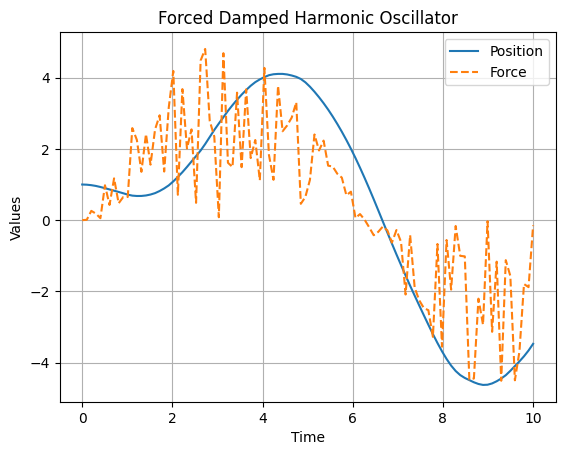

In [13]:
# Plotting the results
import matplotlib.pyplot as plt
plt.plot(t, X[:, 0], label='Position')
plt.plot(t, force, label='Force', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Forced Damped Harmonic Oscillator')
plt.legend()
plt.grid()
plt.show()